## This is the notebook file to perform testing

#### Given that HuggingFace does not disclose the Free tier API usage limits, we will perform some stretch testing.
</br>
By testing i received the message that there's an Hourly limit</br>
"Failed request 429, {"error":"Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate"}. Response Time: 0.33 seconds"

In [1]:
import requests
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import numpy as np

#### The function below is used to simulate requests and measure response time

#### <font color='red'>Make sure to insert your AUTH token from Hugging Face to repeat the tests again</font>



In [2]:
API_URL = "https://api-inference.huggingface.co/models/MaxNardone/model_test"
headers = {"Authorization": "Bearer [INSERT YOUR TOKEN HERE]"}
HEADERS = {
    "Authorization": "Bearer ",
    "Content-Type": "application/json"
}

### 1. Consequent requests testing

In [3]:
def query(payload, retries=3, backoff=1):
    times = []
    for attempt in range(retries):
        start_time = time.time()
        response = requests.post(API_URL, headers=headers, json=payload)
        elapsed_time = time.time() - start_time
        times.append(elapsed_time)
        
        if response.status_code == 200:
            print(f"Success, Response Time: {elapsed_time:.2f} seconds")
            return response, times
        elif response.status_code == 503:
            print(f"Model is loading, retrying... Response Time: {elapsed_time:.2f} seconds")
            time.sleep(backoff * (2 ** attempt))
        else:
            print(f"Failed request {response.status_code}, {response.text}. Response Time: {elapsed_time:.2f} seconds")
            break
    return response, times

def test_rate_limit():
    payload = {
        "inputs": "Light dissolved inorganic carbon (DIC) resulting from the oxidation of hydrocarbons.",
    }
    count = 0
    all_times = []
    while True:
        response, times = query(payload)
        all_times.extend(times)
        if response.status_code != 200:
            print(f"Error after {count} successful requests.")
            print("Status Code:", response.status_code)
            print("Error Response:", response.json())
            break
        count += 1

    #calculate statistics
    avg_time = np.mean(all_times)
    percentile_95 = np.percentile(all_times, 95)
    print(f"Average Response Time: {avg_time:.2f} seconds")
    print(f"95th Percentile Response Time: {percentile_95:.2f} seconds")
    return all_times, avg_time, percentile_95

all_times, avg_time, percentile_95 = test_rate_limit()


Success, Response Time: 0.42 seconds
Success, Response Time: 0.29 seconds
Success, Response Time: 0.32 seconds
Success, Response Time: 0.32 seconds
Success, Response Time: 0.32 seconds
Success, Response Time: 0.30 seconds
Success, Response Time: 0.32 seconds
Success, Response Time: 0.28 seconds
Success, Response Time: 0.30 seconds
Success, Response Time: 0.29 seconds
Success, Response Time: 0.30 seconds
Success, Response Time: 0.30 seconds
Success, Response Time: 0.31 seconds
Success, Response Time: 0.31 seconds
Success, Response Time: 0.29 seconds
Success, Response Time: 0.29 seconds
Success, Response Time: 0.30 seconds
Success, Response Time: 0.30 seconds
Success, Response Time: 0.31 seconds
Success, Response Time: 0.30 seconds
Success, Response Time: 0.31 seconds
Success, Response Time: 0.31 seconds
Success, Response Time: 0.29 seconds
Success, Response Time: 0.30 seconds
Success, Response Time: 0.30 seconds
Success, Response Time: 0.30 seconds
Success, Response Time: 0.31 seconds
S

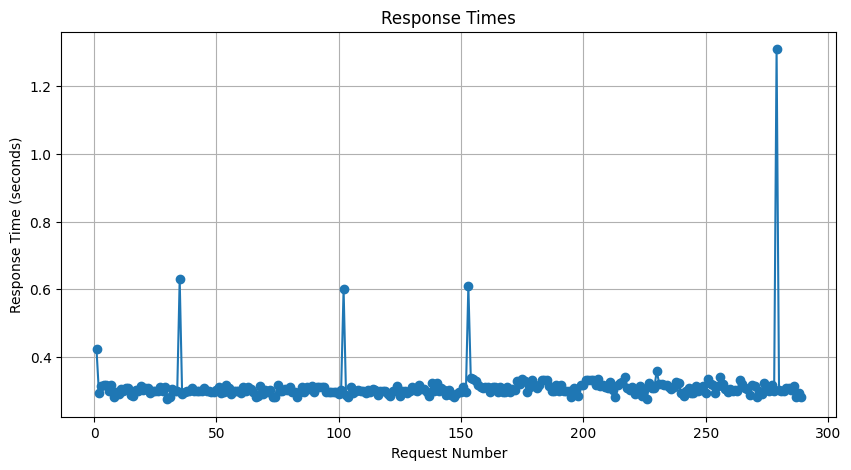

Number of responses until failure:  289


In [6]:
def plot_response_times(times):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(times) + 1), times, marker='o', linestyle='-')
    plt.title('Response Times')
    plt.xlabel('Request Number')
    plt.ylabel('Response Time (seconds)')
    plt.grid(True)
    plt.show()
    print("Number of responses until failure: ", len(times))

plot_response_times(all_times)

### 2. Testing concurrent requests

In [15]:
num_workers = 3 #Number of worker threads in the pool
num_requests_per_batch = 3 #Number of concurrent request
total_requests = 10

In [16]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def send_request(url, payload, headers):
    """Send an HTTP POST request and measure the response time."""
    try:
        start_time = time.time()
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()
        return time.time() - start_time, None
    except requests.RequestException as e:
        return None, str(e)

def run_load_test(url, payload, headers, total_requests, num_requests_per_batch):
    times = []
    errors = []
    
    for _ in range(total_requests // num_requests_per_batch):
        with ThreadPoolExecutor(max_workers=num_requests_per_batch) as executor:
            futures = [executor.submit(send_request, url, payload, headers) for _ in range(num_requests_per_batch)]
            for future in as_completed(futures):
                time_taken, error = future.result()
                if time_taken is not None:
                    times.append(time_taken)
                if error:
                    errors.append(error)
                    print(f"Error logged: {error}")

    return times, errors

payload = {"inputs": "Light dissolved inorganic carbon (DIC) resulting from the oxidation of hydrocarbons."}

#Perform the load test
test_results, test_errors = run_load_test(API_URL, payload, HEADERS, total_requests, num_requests_per_batch)
average_response_time = sum(test_results) / len(test_results) if test_results else 'No successful responses'
print(f"Average Response Time: {average_response_time}")
print(f"Total Errors: {len(test_errors)}")


Error logged: 503 Server Error: Service Unavailable for url: https://api-inference.huggingface.co/models/cccmatthew/surrey-gp30
Error logged: 503 Server Error: Service Unavailable for url: https://api-inference.huggingface.co/models/cccmatthew/surrey-gp30
Error logged: 503 Server Error: Service Unavailable for url: https://api-inference.huggingface.co/models/cccmatthew/surrey-gp30
Error logged: 503 Server Error: Service Unavailable for url: https://api-inference.huggingface.co/models/cccmatthew/surrey-gp30
Error logged: 503 Server Error: Service Unavailable for url: https://api-inference.huggingface.co/models/cccmatthew/surrey-gp30
Error logged: 503 Server Error: Service Unavailable for url: https://api-inference.huggingface.co/models/cccmatthew/surrey-gp30
Error logged: 503 Server Error: Service Unavailable for url: https://api-inference.huggingface.co/models/cccmatthew/surrey-gp30
Error logged: 503 Server Error: Service Unavailable for url: https://api-inference.huggingface.co/models

This error indicates that the number of requests sent to the API exceeds the rate limit set by Hugging Face for the API endpoint. Most APIs enforce rate limits to manage the load on their servers and ensure fair usage among users.
Continuous hitting of this limit results in the API temporarily blocking further requests from your client until the rate limit window resets.

### 3. Testing different payload sizes

Response Times: [0.285994291305542, 0.5389869213104248]
Total Errors: 0


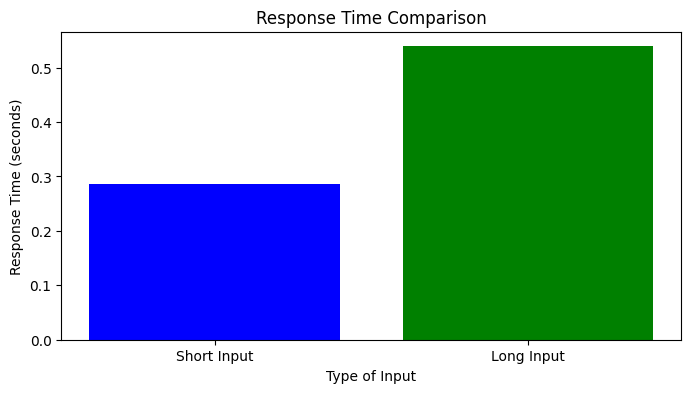

In [12]:
def send_request(url, payload, headers):
    try:
        start_time = time.time()
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()
        return time.time() - start_time, None
    except requests.RequestException as e:
        return None, str(e)

def run_load_test(url, payloads, headers):
    times = []
    errors = []
    
    for payload in payloads:
        time_taken, error = send_request(url, payload, headers)
        if time_taken is not None:
            times.append(time_taken)
        if error:
            errors.append(error)
            print(f"Error logged: {error}")

    return times, errors

def plot_histogram(times):
    plt.figure(figsize=(8, 4))
    plt.bar(['Short Input', 'Long Input'], times, color=['blue', 'green'])
    plt.xlabel('Type of Input')
    plt.ylabel('Response Time (seconds)')
    plt.title('Response Time Comparison')
    plt.show()

#Payloads for testing
payloads = [
    {"inputs": "Images were acquired using a GE 3.0T MRI scanner with an upgrade for echo-planar imaging (EPI)."},
    {"inputs": "Images were acquired using a GE 3.0T MRI scanner with an upgrade for echo-planar imaging (EPI). " * 200}
]

test_results, test_errors = run_load_test(API_URL, payloads, HEADERS)
print(f"Response Times: {test_results}")
print(f"Total Errors: {len(test_errors)}")

plot_histogram(test_results)


### 4. Test the maximum size of the payload

Test with 100 repetitions succeeded in 0.5527248382568359 seconds.
Test with 200 repetitions succeeded in 0.3703017234802246 seconds.
Test with 300 repetitions succeeded in 0.5472695827484131 seconds.
Test with 400 repetitions succeeded in 0.579348087310791 seconds.
Test with 500 repetitions succeeded in 0.7475013732910156 seconds.
Test with 600 repetitions succeeded in 0.7135810852050781 seconds.
Test with 700 repetitions succeeded in 0.6686499118804932 seconds.
Error logged with 800 repetitions: 503 Server Error: Service Unavailable for url: https://api-inference.huggingface.co/models/cccmatthew/surrey-gp30


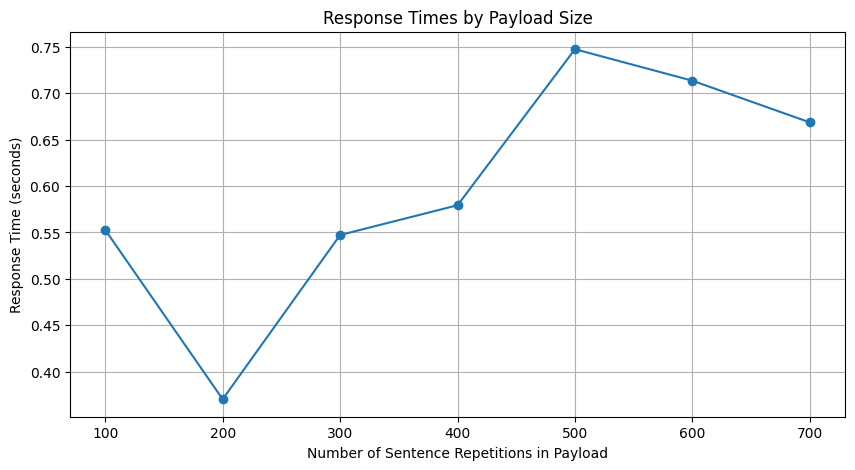

In [13]:
def send_request(url, payload, headers):
    try:
        start_time = time.time()
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()
        return time.time() - start_time, None
    except requests.RequestException as e:
        return None, str(e)

def run_progressive_load_test(url, base_sentence, headers, start, increment, max_attempts):
    times = []
    repetitions = []
    current_repetition = start

    for _ in range(max_attempts):
        payload = {"inputs": base_sentence * current_repetition}
        time_taken, error = send_request(url, payload, headers)
        if time_taken is not None:
            times.append(time_taken)
            repetitions.append(current_repetition)
            print(f"Test with {current_repetition} repetitions succeeded in {time_taken} seconds.")
        if error:
            print(f"Error logged with {current_repetition} repetitions: {error}")
            break
        
        current_repetition += increment

    return times, repetitions

def plot_results(repetitions, times):
    plt.figure(figsize=(10, 5))
    plt.plot(repetitions, times, marker='o')
    plt.title('Response Times by Payload Size')
    plt.xlabel('Number of Sentence Repetitions in Payload')
    plt.ylabel('Response Time (seconds)')
    plt.grid(True)
    plt.show()

base_sentence = "Images were acquired using a GE 3.0T MRI scanner with an upgrade for echo-planar imaging (EPI). "

#Run progressive load test
test_times, test_repetitions = run_progressive_load_test(API_URL, base_sentence, HEADERS, start=100, increment=100, max_attempts=20)
plot_results(test_repetitions, test_times)
